# Get Data, Clean and Normalize

In [1]:
# Imports
import string
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
# Importing data and keeping only wanted cols
df = pd.read_csv('triage_original.csv')
df = df.drop(columns=['subject_id', 'stay_id', 'chiefcomplaint', 'pain'])
df.shape

(425087, 7)

In [3]:
df

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,97.8,87.0,14.0,97.0,71.0,43.0,2.0
1,98.4,70.0,16.0,97.0,106.0,63.0,3.0
2,99.4,105.0,18.0,96.0,106.0,57.0,3.0
3,98.9,88.0,18.0,97.0,116.0,88.0,3.0
4,98.7,77.0,16.0,98.0,96.0,50.0,2.0
...,...,...,...,...,...,...,...
425082,98.0,91.0,16.0,99.0,148.0,90.0,2.0
425083,98.1,83.0,18.0,100.0,107.0,75.0,2.0
425084,96.6,112.0,18.0,100.0,110.0,82.0,2.0
425085,99.5,81.0,10.0,100.0,93.0,55.0,2.0


In [4]:
# Because of excessive amount of data, removing all null valued rows
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.shape

(392462, 7)

In [7]:
df = df[(df["temperature"] >= 51.8) & (df["temperature"] <= 108.14) & (df["heartrate"] > 0) & (df["heartrate"] < 140) & (df["o2sat"] > 0) & (df["o2sat"] < 100)]
df = df.drop(df.loc[df['sbp'] > 400].index) # impossible
df = df.drop(df.loc[df['dbp'] > 400].index) # impossible
df = df.drop(df.loc[df['resprate'] > 200].index) # impossible

In [6]:
df

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,97.8,87.0,14.0,97.0,71.0,43.0,2.0
1,98.4,70.0,16.0,97.0,106.0,63.0,3.0
2,99.4,105.0,18.0,96.0,106.0,57.0,3.0
3,98.9,88.0,18.0,97.0,116.0,88.0,3.0
4,98.7,77.0,16.0,98.0,96.0,50.0,2.0
...,...,...,...,...,...,...,...
392447,97.5,75.0,18.0,99.0,104.0,70.0,3.0
392448,98.4,80.0,18.0,98.0,177.0,98.0,3.0
392449,97.6,112.0,16.0,96.0,158.0,93.0,2.0
392450,96.6,60.0,16.0,99.0,129.0,74.0,2.0


In [8]:
df["acuity"].value_counts()

3.0    118634
2.0     84362
4.0     12792
1.0      8486
5.0       462
Name: acuity, dtype: int64

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-03-10 19:14:41.811203: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 19:14:41.937553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 19:14:42.489284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# Normalizing the data
numerical_cols = ['temperature', 'heartrate', 'o2sat', 'sbp', 'dbp', 'resprate']
for col in numerical_cols:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

# SMOTE

In [11]:
# Oversample and plot imbalanced dataset with SMOTE
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

In [12]:
df

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,-0.300801,0.100170,-1.399974,-0.092946,-2.835714,-2.249201,2.0
1,0.287210,-0.901347,-0.620431,-0.092946,-1.288232,-0.927733,3.0
2,1.267228,1.160599,0.159111,-0.497609,-1.288232,-1.324174,3.0
3,0.777219,0.159082,0.159111,-0.092946,-0.846095,0.724101,3.0
4,0.581215,-0.488958,-0.620431,0.311717,-1.730370,-1.786687,2.0
...,...,...,...,...,...,...,...
392447,-0.594806,-0.606783,0.159111,0.716380,-1.376660,-0.465220,3.0
392448,0.287210,-0.312219,0.159111,0.311717,1.850944,1.384835,3.0
392449,-0.496805,1.572988,-0.620431,-0.497609,1.010883,1.054468,2.0
392450,-1.476823,-1.490474,-0.620431,0.716380,-0.271316,-0.200926,2.0


In [13]:
X = df.drop(['acuity'], axis=1).to_numpy()
y = df['acuity'].to_numpy()
counter = Counter(y)
print(counter)

Counter({3.0: 118634, 2.0: 84362, 4.0: 12792, 1.0: 8486, 5.0: 462})


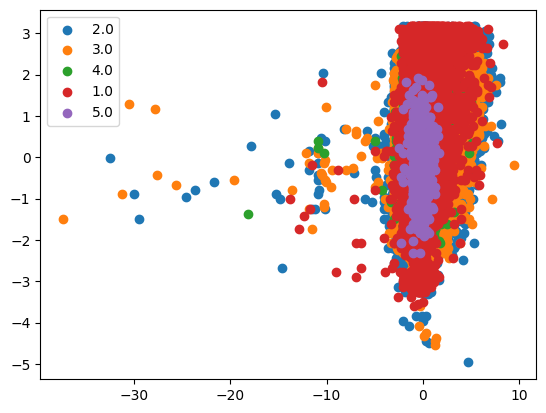

In [15]:
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [16]:
over = SMOTE(sampling_strategy={1: 118634, 2: 118634, 3: 118634, 4: 118634, 5: 118634})
# under = RandomUnderSampler(sampling_strategy={1: 117852, 2: 117852, 3: 117852, 4: 117852, 5: 117852})
steps = [('o', over),]
pipeline = Pipeline(steps=steps)

X, y = pipeline.fit_resample(X, y)

In [17]:
counter = Counter(y)
print(counter)

Counter({2.0: 118634, 3.0: 118634, 4.0: 118634, 1.0: 118634, 5.0: 118634})


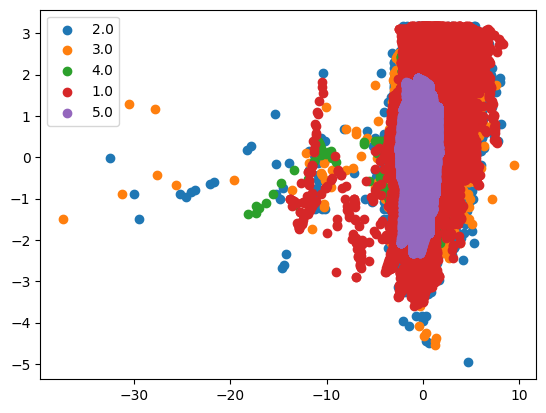

In [18]:
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [24]:
X.shape

(593170, 6)

In [20]:
import numpy as np
import pandas as pd

# Concatenate X and y numpy arrays
Xy = np.concatenate((X, y.reshape(-1, 1)), axis=1)

In [21]:
!pwd

/media/csuser/DATA/ARTEMIS/mimic


In [25]:

# Create a pandas DataFrame from the concatenated array
#new_keys.remove('esi')
#new_keys.append('esi')
new_keys = ['temperature', 'heartrate', 'resprate',	'o2sat', 'sbp',	'dbp', 'acuity']
df = pd.DataFrame(data=Xy, columns=new_keys)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593170 entries, 0 to 593169
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  593170 non-null  float64
 1   heartrate    593170 non-null  float64
 2   resprate     593170 non-null  float64
 3   o2sat        593170 non-null  float64
 4   sbp          593170 non-null  float64
 5   dbp          593170 non-null  float64
 6   acuity       593170 non-null  float64
dtypes: float64(7)
memory usage: 31.7 MB


In [26]:
df.to_csv('/media/csuser/DATA/ARTEMIS/mimic/triage_smote7.csv', index=False)

# Neural Network

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch

In [29]:
df = pd.read_csv('/media/csuser/DATA/ARTEMIS/mimic/triage_smote7.csv')

# Split the data into features (X) and target (y)
print(df.shape)
x = df.drop(['acuity'], axis=1)
y = df['acuity']

x = x.to_numpy().astype(np.float32)
y = y.to_numpy().reshape(-1,1).astype(np.int_)

print(np.asarray(x))

# x = tf.constant(np.asarray(x), dtype=tf.float64)
# y = tf.constant(np.asarray(y).reshape(-1, 1), dtype=tf.float64)

print(x.shape)

# convert to one hot vector
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y)
print(ohe.categories_)

y = ohe.transform(y)
y.shape

(593170, 7)
[[-0.30080092  0.10016959 -1.3999738  -0.09294572 -2.8357136  -2.2492008 ]
 [ 0.28720993 -0.90134674 -0.6204313  -0.09294572 -1.2882322  -0.9277333 ]
 [ 1.267228    1.1605986   0.15911114 -0.4976085  -1.2882322  -1.3241736 ]
 ...
 [-0.37229583 -0.6545861  -1.3999738   0.3482006  -0.1426608  -0.08069345]
 [-0.34623998 -0.5435881  -1.3999738   0.09467843 -0.11496077  0.2501634 ]
 [ 0.1212853  -1.2446153  -0.6204313  -0.97238696 -0.7517578  -0.24050672]]
(593170, 6)
[array([1, 2, 3, 4, 5])]


(593170, 5)

In [30]:
df.head()

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity
0,-0.300801,0.100170,-1.399974,-0.092946,-2.835714,-2.249201,2.0
1,0.287210,-0.901347,-0.620431,-0.092946,-1.288232,-0.927733,3.0
2,1.267228,1.160599,0.159111,-0.497609,-1.288232,-1.324174,3.0
3,0.777219,0.159082,0.159111,-0.092946,-0.846095,0.724101,3.0
4,0.581215,-0.488958,-0.620431,0.311717,-1.730370,-1.786687,2.0


In [32]:
# Building a basic model
# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     dense1 = layers.Dense(units=128, activation='LeakyReLU', use_bias=True,)(inputs)
#     dense2 = layers.Dense(units=64, activation='LeakyReLU', use_bias=True,)(dense1)
#     dense3 = layers.Dense(units=32, activation='LeakyReLU', use_bias=True,)(dense2)
#     dense4 = layers.Dense(units=128, activation='LeakyReLU', use_bias=True,)(dense3)
#     dense5 = layers.Dense(units=64, activation='LeakyReLU', use_bias=True,)(dense4)
#     dense6 = layers.Dense(units=32, activation='LeakyReLU', use_bias=True,)(dense5)
#     dense7 = layers.Dense(units=32, activation='LeakyReLU', use_bias=True,)(dense6)
#     output = layers.Dense(units=num_classes, activation='softmax')(dense7)
#     return keras.Model(inputs, output)
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    dense1 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(inputs)
    dense2 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(dense1)
    dense3 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(dense2)
    dense4 = layers.Dense(units=50, activation='ReLU', use_bias=True,)(dense3)
    output = layers.Dense(units=num_classes, activation='softmax')(dense4)
    return keras.Model(inputs, output)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.20, random_state=1)

In [34]:
model = make_model(input_shape=(6), num_classes=y[0].shape[0])
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.01, weight_decay=1e-6),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["accuracy"],
)
model.summary()

# make the save callback
best_model_path = '/media/csuser/DATA/ARTEMIS/models/mimic_smote'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# load the saved model by:
# model.load_weights(best_model_path)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 50)                350       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 5)                 255       
                                                                 
Total params: 8,255
Trainable params: 8,255
Non-trainable par

2024-03-10 19:47:26.990562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-03-10 19:47:26.990589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: IDEAS8
2024-03-10 19:47:26.990592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: IDEAS8
2024-03-10 19:47:26.990720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.161.7
2024-03-10 19:47:26.990738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.154.5
2024-03-10 19:47:26.990741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration


In [35]:
history = (model.fit(X_train, y_train, epochs=5000, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback]))
#history = (model.fit(X_train, y_train, epochs=5000, validation_data=(X_val, y_val)))

Epoch 1/5000
11864/11864 [==============================] - 7s 586us/step - loss: 0.1278 - accuracy: 0.4578 - val_loss: 0.1210 - val_accuracy: 0.4948
Epoch 2/5000
11864/11864 [==============================] - 7s 583us/step - loss: 0.1173 - accuracy: 0.5096 - val_loss: 0.1151 - val_accuracy: 0.5189
Epoch 3/5000
11864/11864 [==============================] - 7s 571us/step - loss: 0.1138 - accuracy: 0.5244 - val_loss: 0.1137 - val_accuracy: 0.5246
Epoch 4/5000
11864/11864 [==============================] - 7s 568us/step - loss: 0.1119 - accuracy: 0.5312 - val_loss: 0.1116 - val_accuracy: 0.5315
Epoch 5/5000
11864/11864 [==============================] - 7s 572us/step - loss: 0.1106 - accuracy: 0.5376 - val_loss: 0.1116 - val_accuracy: 0.5347
Epoch 6/5000
11864/11864 [==============================] - 7s 574us/step - loss: 0.1096 - accuracy: 0.5417 - val_loss: 0.1101 - val_accuracy: 0.5386
Epoch 7/5000
11864/11864 [==============================] - 7s 587us/step - loss: 0.1089 - accuracy:

# PREDICT AND PLOT

##### For 5000 epochs, from data saved in history

In [36]:
!pwd

/media/csuser/DATA/ARTEMIS/mimic


In [37]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


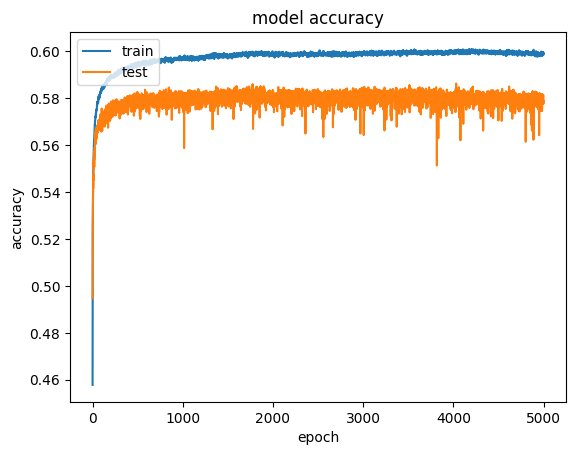

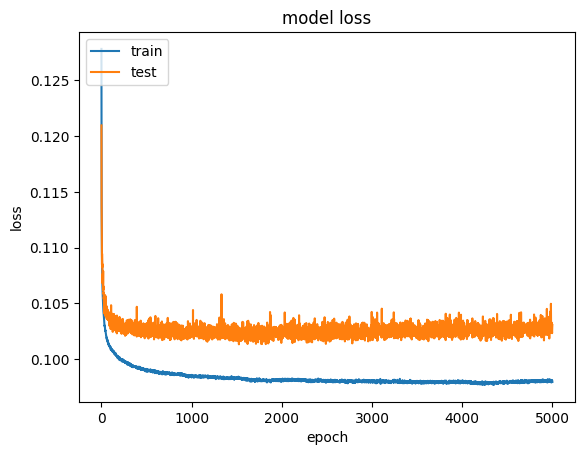

In [38]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/media/csuser/DATA/ARTEMIS/mimic/figs/NN_ACCURACYvsEPOCHS.png', dpi=500)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/media/csuser/DATA/ARTEMIS/mimic/figs/NN_LOSSvsEPOCHS.png', dpi=500)
plt.show()

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model.load_weights('/media/csuser/DATA/ARTEMIS/models/mimic_smote')

(118634, 6)
3708/3708 [==============================] - 1s 314us/step
(118634, 5)
(118634, 5)
[4 2 1 ... 4 0 4]
[4 3 2 ... 4 0 4]


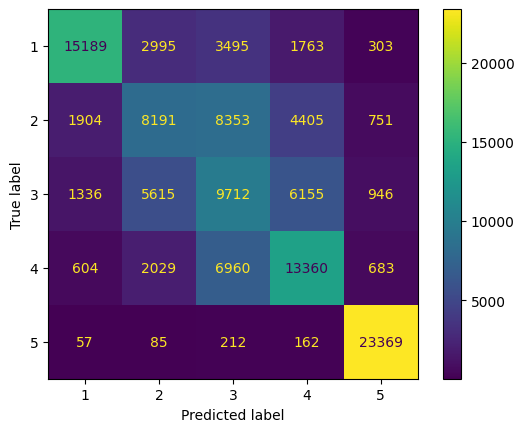

In [40]:
# CONFUSION MATRIX
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report, recall_score, ConfusionMatrixDisplay
from numpy import argmax

print(X_test.shape)
y_pred = model.predict(X_test)
print(y_test.shape)
print(y_pred.shape)
y_test = argmax(a=y_test, axis=1)
y_pred = argmax(a=y_pred, axis=1)
print(y_test)
print(y_pred)
ConfusionMatrixDisplay.from_predictions(y_test+1, y_pred+1)
plt.savefig('/media/csuser/DATA/ARTEMIS/mimic/figs/NN_confusion_mimic_smote.png', dpi=500)

In [41]:
y_pred

array([4, 3, 2, ..., 4, 0, 4])

In [42]:
TP = np.zeros(5)
FP = np.zeros(5)
FN = np.zeros(5)

for i in range(5):
    for j in range(len(y_test)):
        if y_test[j] == i and y_pred[j] == i:
            TP[i] += 1
        elif y_test[j] == i and y_pred[j] != i:
            FN[i] += 1
        elif y_test[j] != i and y_pred[j] == i:
            FP[i] += 1
print(TP, FN, FP)

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# F1
F1 = 2 * (PPV * TPR) / (PPV + TPR)

# Overall accuracy
ACC = np.zeros(5)
class_totals = np.zeros(5)
for i in range(5):
    for j in range(len(y_test)):
        class_totals[y_test[j]] += 1
        if y_test[j] == y_pred[j]:
            ACC[y_test[j]] += 1
ACC /= class_totals

print(PPV, TPR, F1, ACC)

[15189.  8191.  9712. 13360. 23369.] [ 8556. 15413. 14052. 10276.   516.] [ 3901. 10724. 19020. 12485.  2683.]
[0.79565217 0.43304256 0.33802033 0.51692784 0.89701366] [0.63967151 0.34701745 0.40868541 0.56523947 0.97839648] [0.70918641 0.38528658 0.37000914 0.54000525 0.93593928] [0.63967151 0.34701745 0.40868541 0.56523947 0.97839648]


In [43]:
acc = accuracy_score(y_test, y_pred)
print('Acc: ', acc)

prec = precision_score(y_test, y_pred, average='weighted')
print('Prec: ', prec)

recall = recall_score(y_test, y_pred, average='weighted')
print('Recall: ', recall)

Acc:  0.588541227641317
Prec:  0.5967116529914185
Recall:  0.588541227641317


In [ ]:
# import numpy as np

# def metrics(y_test, y_pred):
#     model_metrics = {}
#     max_indices = np.argmax(y_test, axis=1)
#     y_test = max_indices + 1
    
#     max_indices = np.argmax(y_pred, axis=1)
#     y_pred = max_indices + 1

#     lab = [1, 2, 3, 4,5]
    
#     for j in lab:
#         TP, FP, FN, TN = 0, 0, 0, 0
        
#         for i in range(len(y_test)):
#             if y_test[i] == j and y_pred[i] == j:
#                 TP += 1
#             elif y_test[i] == j and y_pred[i] != j:
#                 FN += 1
#             elif y_test[i] != j and y_pred[i] != j:
#                 TN += 1
#             else:
#                 FP += 1
        
#         # Check if TP + FP or TP + FN is zero before calculating precision and recall
#         if TP + FP == 0:
#             precision = 0  # Avoid division by zero
#         else:
#             precision = TP / (TP + FP)
        
#         if TP + FN == 0:
#             recall = 0  # Avoid division by zero
#         else:
#             recall = TP / (TP + FN)
        
#         if precision + recall == 0:
#             f1_score = 0  # Avoid division by zero
#         else:
#             f1_score = 2 * (precision * recall) / (precision + recall)
        
#         model_metrics[j] = {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "precision": precision, "recall": recall, "f1_score": f1_score}

#     return model_metrics


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
decision_model_metrics = metrics(y_test,y_pred)

In [ ]:
decision_model_metrics

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
y_test

In [ ]:
y_pred

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test.ravel(),
    y_pred.ravel(),
    name="micro-average OvR",
    color="darkorange",
    # plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
y_onehot_test

In [ ]:
label_binarizer.transform([2])

In [ ]:
class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

In [ ]:
class_id

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    # plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
class_id = 2
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
class_id = 3
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
class_id = 4
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
class_id = 0
RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


classes = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid of subplots
axes[1][2].set_visible(False)

for i, class_id in enumerate(range(5)):  # Assuming class IDs start from 0
    ax = axes[i//3, i%3]  # Calculate the subplot position

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred[:, class_id],
        name=f"{classes[class_id]} vs the rest",
        color="darkorange",
        ax=ax  # Assign the subplot to the current axis
    )


    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"One-vs-Rest ROC curves:\n{classes[class_id]} vs the rest")

# Adjust layout
plt.tight_layout()

plt.show()


In [ ]:
trained_models, histories = [], []
n_models, epochs = 50, 5
k_fold = KFold(n_models)
precision_list =[]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, train_size= .80)
print(X_train.shape)

for train_indices, test_indices in k_fold.split(X_train):
    

    x1_train, y1_train = X_train[train_indices], y_train[train_indices]
    x_val, y_val = X_train[test_indices], y_train[test_indices]

    model = make_model(input_shape=(3), num_classes=y[0].shape[0])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    histories.append(model.fit(x1_train, 
                               y1_train, epochs=epochs, 
                               validation_data = (x_val, y_val)))
    
    y_pred = model.predict(x_val)

    max_indices = np.argmax(y_val, axis=1)
    y_val = max_indices + 1
    
    max_indices = np.argmax(y_pred, axis=1)
    y_pred = max_indices + 1

    precision = precision_score(y_val, y_pred, average="weighted")
    precision_list.append(precision)


In [ ]:
precision_list_tree = [0.8972521324493244,
 0.9050329118957142,
 0.9172165785303346,
 0.9175694235195049,
 0.9139132652340948,
 0.9096529140079395,
 0.9078916812978447,
 0.9153345053308668,
 0.9118285116259086,
 0.9133121102389169,
 0.91744960217773,
 0.9138128592901759,
 0.9044372628516312,
 0.9140189283935687,
 0.9094207999093339,
 0.906279433297611,
 0.9063441393735263,
 0.9053194111756259,
 0.9091978425159323,
 0.9098494096774302,
 0.9097243747747501,
 0.9099392260190308,
 0.9154556745915264,
 0.9138648099118555,
 0.911321089947818,
 0.915020827018602,
 0.9136860444519458,
 0.9112126939278078,
 0.9111347167929121,
 0.923757248001491,
 0.9098571647375098,
 0.911523865134343,
 0.9157113959446195,
 0.9090935771592038,
 0.908241820015837,
 0.9075461264489019,
 0.9178407627325489,
 0.9095257235955037,
 0.9106117861661375,
 0.9095200584734341,
 0.903466873778968,
 0.9138346720559205,
 0.9124146422885498,
 0.8983497657654559,
 0.9153151750439699,
 0.9115851522533573,
 0.9124306328513269,
 0.9027732209987848,
 0.9056067200706398,
 0.9094318386348679]

In [ ]:
import scipy.stats as stats
# conduct the Wilcoxon-Signed Rank Test
stats.wilcoxon(precision_list, precision_list_tree)

In [ ]:
precision_list

In [ ]:
count = 0
for i in range(len(precision_list)):
    if precision_list[i] > precision_list_tree[i]:
        count += 1


In [ ]:
count